# Engineering Notebook

## By Rakesh Nori, Soham Bose

This is the engineering notebook for the second design project in CS 262. Our assignment was to build a model of a small, asynchronous distributed system that runs on a single machine but models multiple machines, each with their own logical clock, that run at different speeds.

## Initialization

To begin the process of initialization, 3 separate processes are created, with each serving as a virtual machine. The configuration parameters for each process include the local host address, server/consumer port, two producer ports, and the randomly generated clock rate. For each process, global variables according to the random code, message queue, logical clock, and locks for the queue, clock, and log are initialized. The final step of initialization steps is to create a log file for each of the separate ports where relevant information is stored.

## Producers and Consumers

After initialization is done for each process, a thread is created for the consumer, which acts as a server that binds to a port and listens to connections from producers from other machines. Each producer from the other machine that connects to the consumer port causes a new thread to be created. The consumer thread is responsible for receiving messages from producers and adding them to the message queue. Locks are placed on the message queue in order to avoid race conditions where the queue is accessed or changed out of turn. After the consumer thread is created, a delay is added in order to allow the listeners to have time to be ready and two producer threads are created. Each producer thread is associated with a number 1 or 2 which is associated with the randomly generated $code$ value, allowing us to differentiate which machine information must be sent to.  

The producer thread is responsible for sending messages to the consumer on the other virtual machines. Each producer thread is associated with a port that isn't being used by the consumer. Additionally, we decided to add a delay of $\frac{1}{rate}$ seconds after the first producer thread was started in order to guarantee that only $rate$ number of instructions could be performed per real world second on the virtual machine. We also added a delay of $\frac{2}{rate}$ seconds between each new code being generated. The delay is $\frac{2}{rate}$ since there are 2 threads, each of which need a delay of $\frac{1}{rate}$, and we don't want a new code to be created and accessed by a thread before all threads are finished processing the action corresponding to the initially generated code.  

## Clock Cycle Logic

For all local logical clock updates, we implemented a locking mechanism to prevent race conditions where the clock is accessed or changed out of turn. Similarly, we implemented a locking mechanism for the printed events as well to avoid any possible race conditions. A locking mechanism was also implemented whenever anything was read from the message queue.

Within the producer thread exists the call to the function $update$, which defines the clock cycle logic that updates the local logical clock of each virtual machine. To start, we looked at defining the case where there were messages in the queue of the machine that needed to be read. For this case, we have received a message containing the local logical clock time of another machine, which needs to be read and then compared to the current machine's local logical clock time. In accordance with the principles of a Lamport clock, the maximum time is chosen as the current machine's new local logical clock time, with 1 added since a message was read and an operation was done.

We then began by defining the simple cases of the generated $code$ being 1 or 2, in which case we took advantage of the number associated with each producer thread to match with the generated $code$ value and send the local logical clock time to the correct virtual machine, update the local logical clock, and print a log that a message was sent. We then took care of the other simpler case where $code \geq 4$, in which case an internal event log was printed and the local logical clock was updated. 

Once the simpler cases were implemented, we moved on to the case where $code = 3$. To start, an array $finished$ was defined in order to track which of the machines had messages sent to it. Initially, when the first thread enters the loop, the message containing the logical clock time is immediately sent to the first machine, after which the number associated with the virtual machine that the message was sent to was added to the $finished$ array to signify that the operation had been finished. No clock update was made since the full operation associated with the code being 3 hadn't been finished. Next, to define the behavior when the second thread enters the loop, the logical clock time was also immediately sent to the associated machine but the following logic was changed in order to allow for reusability. We decided to check if $finished$ was already populated in order to know that the first thread had already gone through it's intended behavior and then decide to reset the $finished$ array, update the clock since the entire operation had now been finished, and log that a message had been sent to both machines. 

We added an edge case where the code may change before both threads are able to run by checking if our $finished$ array was not empty and the code was not 3, which meant that the behavior of the 2nd thread hadn't occurred since the $finished$ array wasn't cleared. In this case where the $code$ had been wrongly updated before the full behavior of both threads had occurred, we immediately force the behavior of the 2nd thread to occur where the logical clock time is sent to the associated machine, $finished$ is cleared, the clock is updated, and a message sent event is logged. 

## Experiments

In [116]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

In [117]:
port_1 = pd.read_fwf("log_2056.txt", header = None)
unparsed_events_1 = port_1[0][5:].values

In [118]:
print(unparsed_events_1)

['msg received, time: 1678237601.447999, 0, 1'
 'internal event, time: 1678237601.6489348, 2'
 'internal event, time: 1678237601.851083, 3'
 'internal event, time: 1678237602.0531719, 4'
 'internal event, time: 1678237602.2561421, 5'
 'internal event, time: 1678237602.456482, 6'
 'msg received, time: 1678237602.660148, 0, 7'
 'internal event, time: 1678237603.0641248, 8'
 'internal event, time: 1678237603.264268, 9'
 'msg sent, time: 1678237603.668861, 10'
 'internal event, time: 1678237603.868085, 11'
 'internal event, time: 1678237604.070435, 12'
 'msg sent, time: 1678237604.273206, 13'
 'msg sent, time: 1678237604.677661, 14'
 'msg received, time: 1678237605.0808089, 0, 15'
 'internal event, time: 1678237605.27697, 16'
 'internal event, time: 1678237605.481289, 17'
 'msg received, time: 1678237605.68034, 0, 18'
 'msg sent, time: 1678237606.08431, 19'
 'internal event, time: 1678237606.287551, 20'
 'internal event, time: 1678237606.489314, 21'
 'internal event, time: 1678237606.69158

In [119]:
event_dict_1 = {}
for event in unparsed_events_1:
    event = event[:event.find(",")]
    if event in event_dict_1:
        event_dict_1[event] += 1
    else:
        event_dict_1[event] = 1
print(event_dict_1)

{'msg received': 44, 'internal event': 220, 'msg sent': 46}


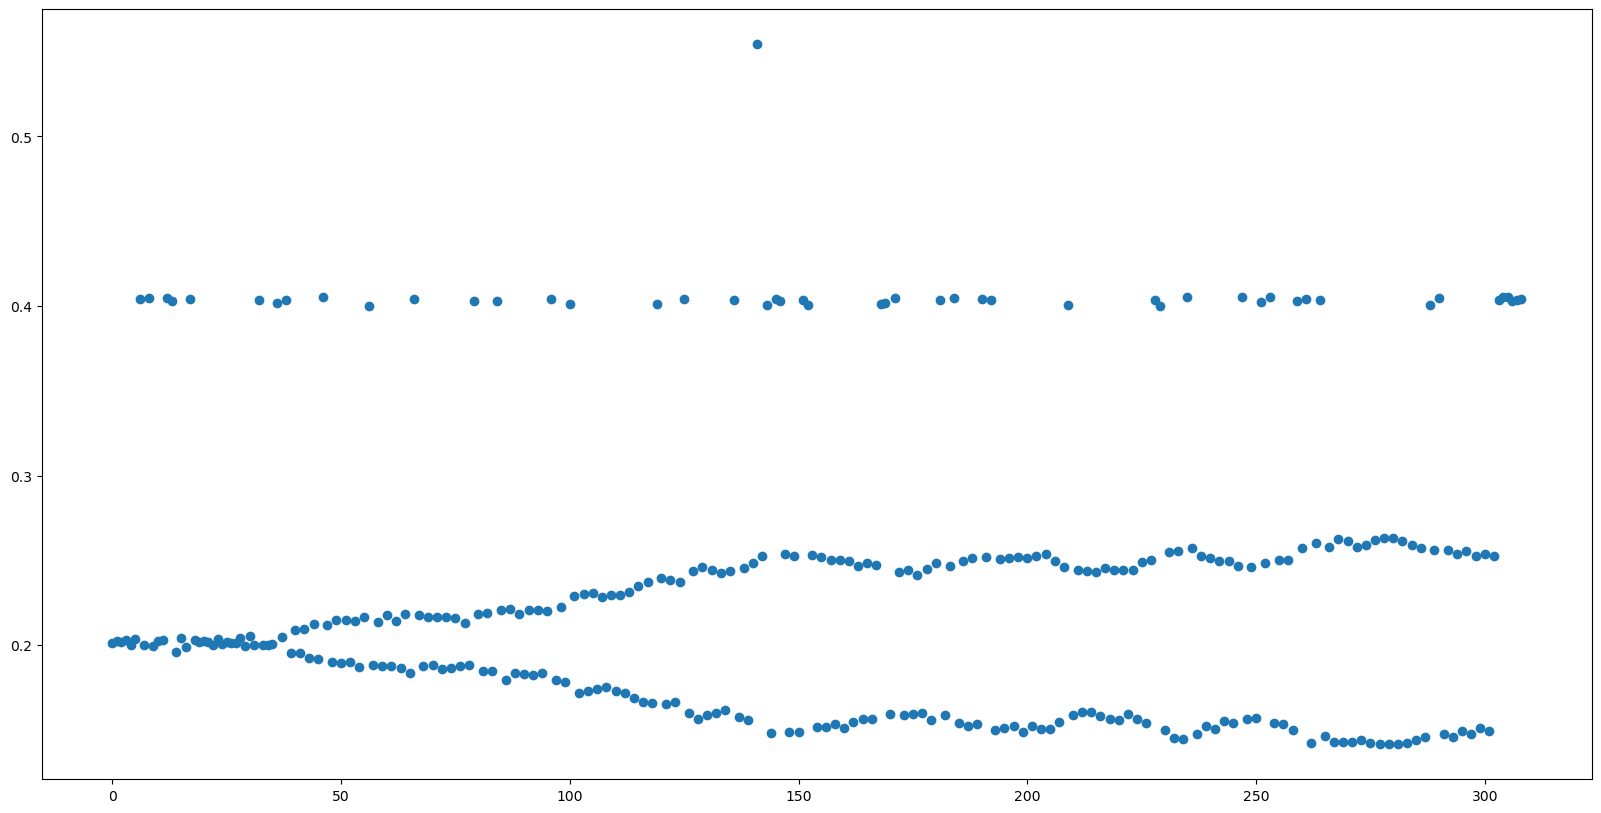

In [120]:
times_1 = []
for event in unparsed_events_1:
    first_loc = event.find(":")
    times_1.append(float(event[first_loc+1:event.find(",", first_loc + 1)]))
    
time_dif_1 = [times_1[i + 1] - times_1[i] for i in range(len(times_1) - 1)]

plt.rcParams["figure.figsize"] = (20, 10)

plt.scatter(np.arange(len(time_dif_1)), time_dif_1)
plt.show()

In [121]:
print(times_1[-1] - times_1[0])
print(len(unparsed_events_1))

72.37073302268982
310


In [125]:
port_2 = pd.read_fwf("log_3056.txt", header = None)
unparsed_events_2 = port_2[0][5:].values

In [127]:
print(unparsed_events_2)

['internal event, time: 1678237601.244645, 1'
 'internal event, time: 1678237601.4951942, 2'
 'internal event, time: 1678237601.746919, 3'
 'msg received, time: 1678237601.997539, 0, 4'
 'msg sent, time: 1678237602.4976, 5'
 'internal event, time: 1678237602.748867, 6'
 'internal event, time: 1678237602.997733, 7'
 'internal event, time: 1678237603.2500029, 8'
 'internal event, time: 1678237603.49881, 9'
 'msg received, time: 1678237603.7502599, 0, 10'
 'internal event, time: 1678237604.000233, 11'
 'internal event, time: 1678237604.255319, 12'
 'internal event, time: 1678237604.50026, 13'
 'msg sent, time: 1678237605.0054002, 14'
 'msg sent, time: 1678237605.510228, 15'
 'internal event, time: 1678237605.765707, 16'
 'internal event, time: 1678237606.014129, 17'
 'msg received, time: 1678237606.270227, 0, 19'
 'internal event, time: 1678237606.514605, 20'
 'msg sent, time: 1678237607.015548, 21'
 'internal event, time: 1678237607.280372, 22'
 'internal event, time: 1678237607.517129, 

In [128]:
event_dict_2 = {}
for event in unparsed_events_2:
    event = event[:event.find(",")]
    if event in event_dict_2:
        event_dict_2[event] += 1
    else:
        event_dict_2[event] = 1
print(event_dict_2)

{'internal event': 168, 'msg received': 48, 'msg sent': 37}


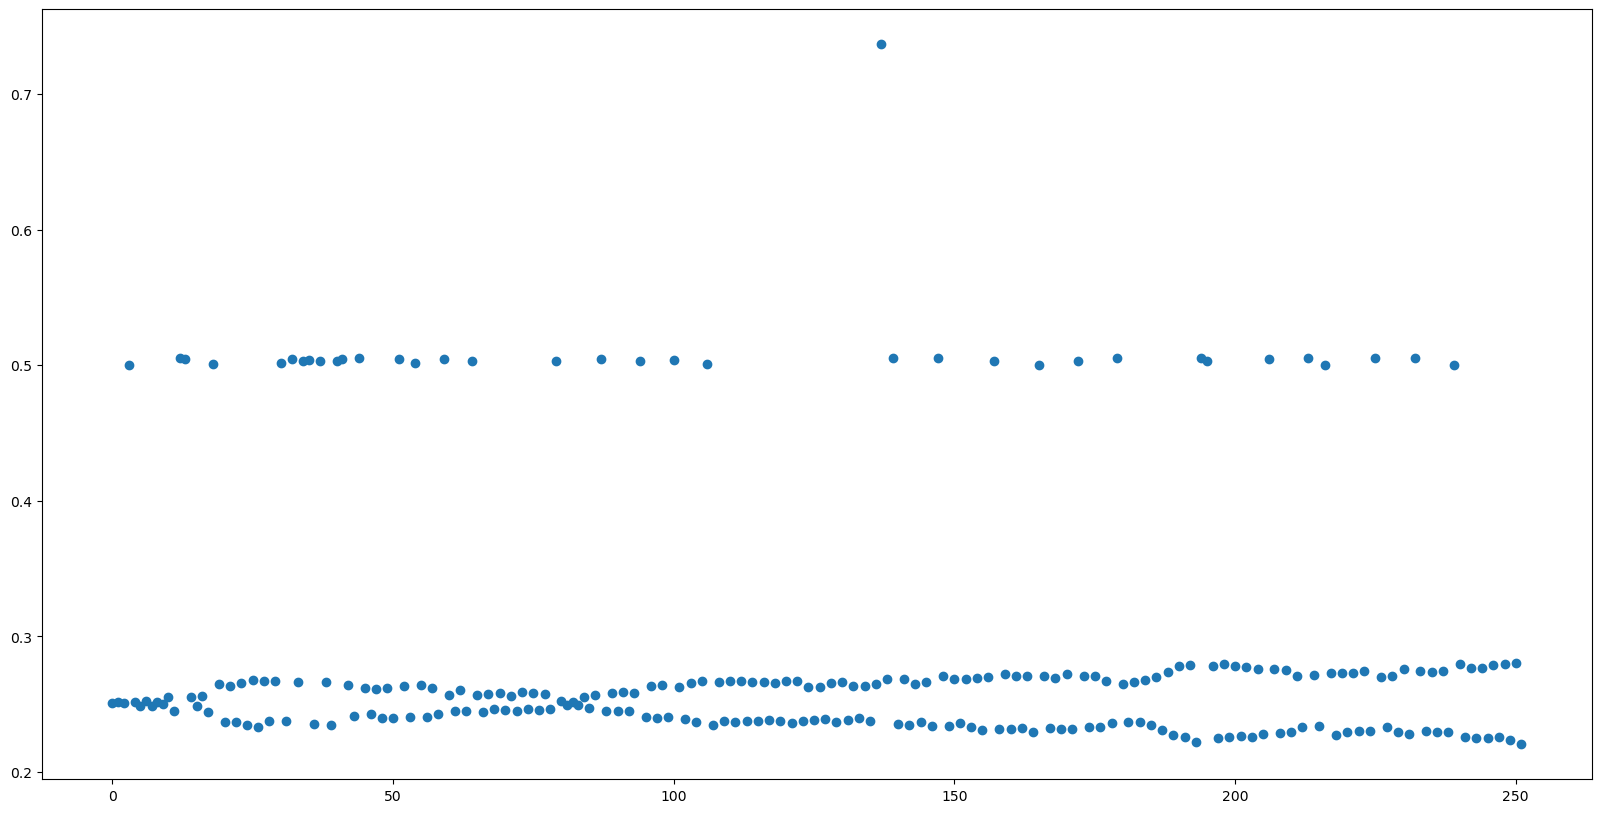

In [129]:
times_2 = []
for event in unparsed_events_2:
    first_loc = event.find(":")
    times_2.append(float(event[first_loc+1:event.find(",", first_loc + 1)]))
    
time_dif_2 = [times_2[i + 1] - times_2[i] for i in range(len(times_2) - 1)]

plt.rcParams["figure.figsize"] = (20, 10)

plt.scatter(np.arange(len(time_dif_2)), time_dif_2)
plt.show()

In [130]:
print(times_2[-1] - times_2[0])
print(len(unparsed_events_2))

72.67004585266113
253


In [133]:
port_3 = pd.read_fwf("log_4056.txt", header = None)
unparsed_events_3 = port_3[0][5:].values

In [134]:
print(unparsed_events_3)

['msg sent, time: 1678237601.746976, 1'
 'internal event, time: 1678237602.247416, 2'
 'msg received, time: 1678237602.748938, 0, 5'
 'internal event, time: 1678237603.2483368, 6'
 'internal event, time: 1678237603.750269, 7'
 'internal event, time: 1678237604.249048, 8'
 'msg received, time: 1678237604.7523332, 1, 13'
 'msg received, time: 1678237605.253675, 1, 14'
 'msg received, time: 1678237605.7557151, 0, 15'
 'msg received, time: 1678237606.258016, 0, 19'
 'internal event, time: 1678237606.76015, 20'
 'msg received, time: 1678237607.260176, 0, 21'
 'msg sent, time: 1678237608.7686322, 22'
 'msg sent, time: 1678237609.77247, 23'
 'internal event, time: 1678237610.2684538, 24'
 'msg received, time: 1678237610.7768698, 0, 38'
 'msg received, time: 1678237611.7816918, 0, 41'
 'msg received, time: 1678237612.272257, 0, 42'
 'msg received, time: 1678237612.7843788, 0, 48'
 'msg sent, time: 1678237613.276858, 49'
 'msg received, time: 1678237613.788803, 0, 52'
 'msg received, time: 1678

In [135]:
event_dict_3 = {}
for event in unparsed_events_3:
    event = event[:event.find(",")]
    if event in event_dict_3:
        event_dict_3[event] += 1
    else:
        event_dict_3[event] = 1
print(event_dict_3)

{'msg sent': 17, 'internal event': 60, 'msg received': 50}


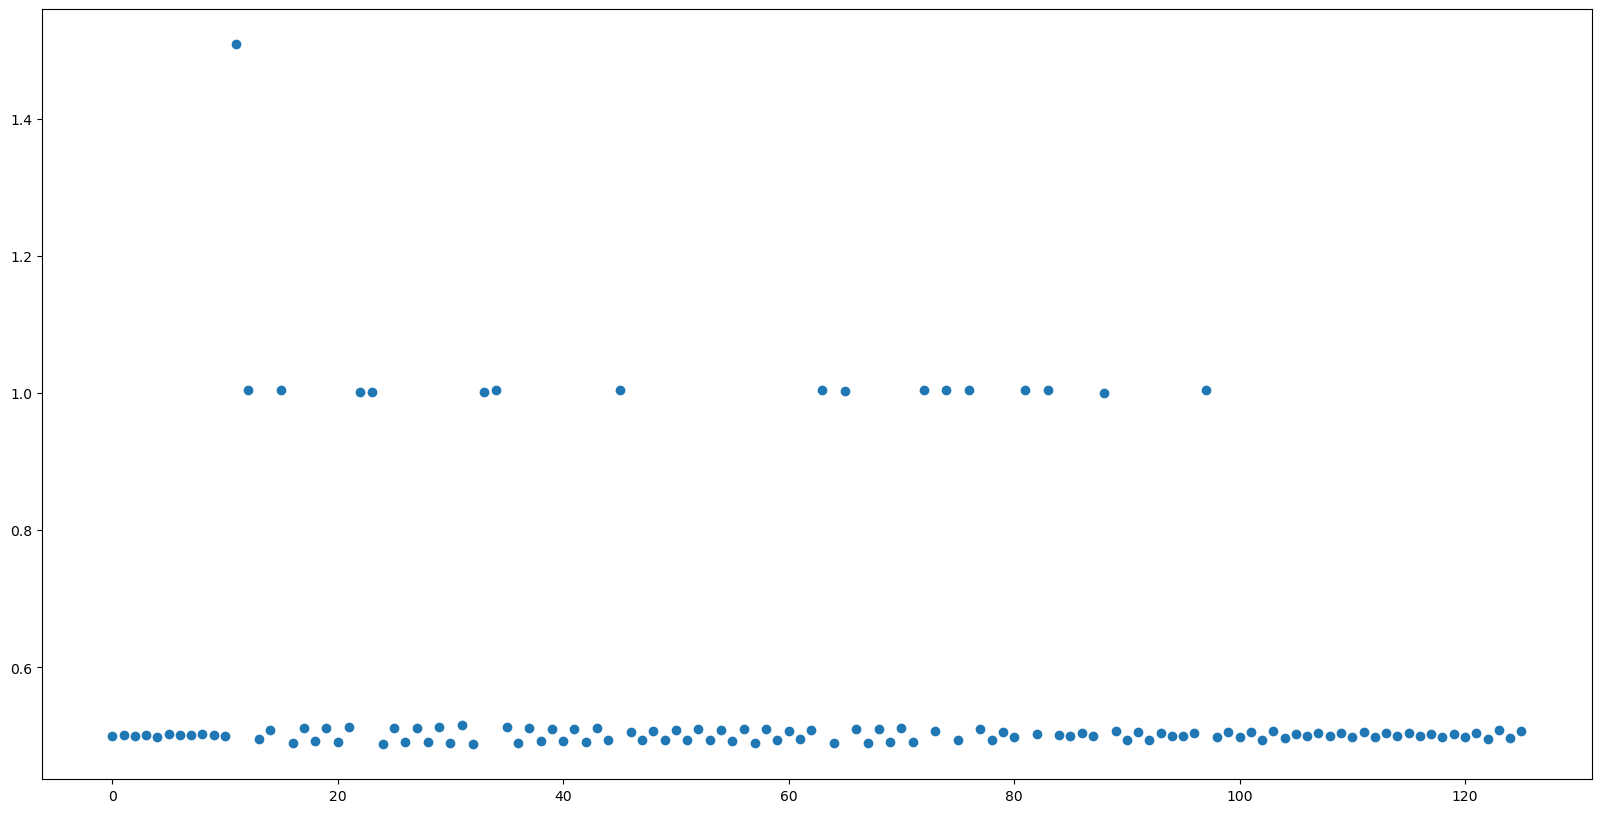

In [136]:
times_3 = []
for event in unparsed_events_3:
    first_loc = event.find(":")
    times_3.append(float(event[first_loc+1:event.find(",", first_loc + 1)]))
    
time_dif_3 = [times_3[i + 1] - times_3[i] for i in range(len(times_3) - 1)]

plt.rcParams["figure.figsize"] = (20, 10)

plt.scatter(np.arange(len(time_dif_3)), time_dif_3)
plt.show()

In [137]:
print(times_3[-1] - times_3[0])
print(len(unparsed_events_3))

72.21499919891357
127


In [142]:
logical_clock_1 = []
for event in unparsed_events_1:
    logical_clock_1.append(int(event[event.rfind(',') + 2:]))

logical_clock_2 = []
for event in unparsed_events_2:
    logical_clock_2.append(int(event[event.rfind(',') + 2:]))

logical_clock_3 = []
for event in unparsed_events_3:
    logical_clock_3.append(int(event[event.rfind(',') + 2:]))

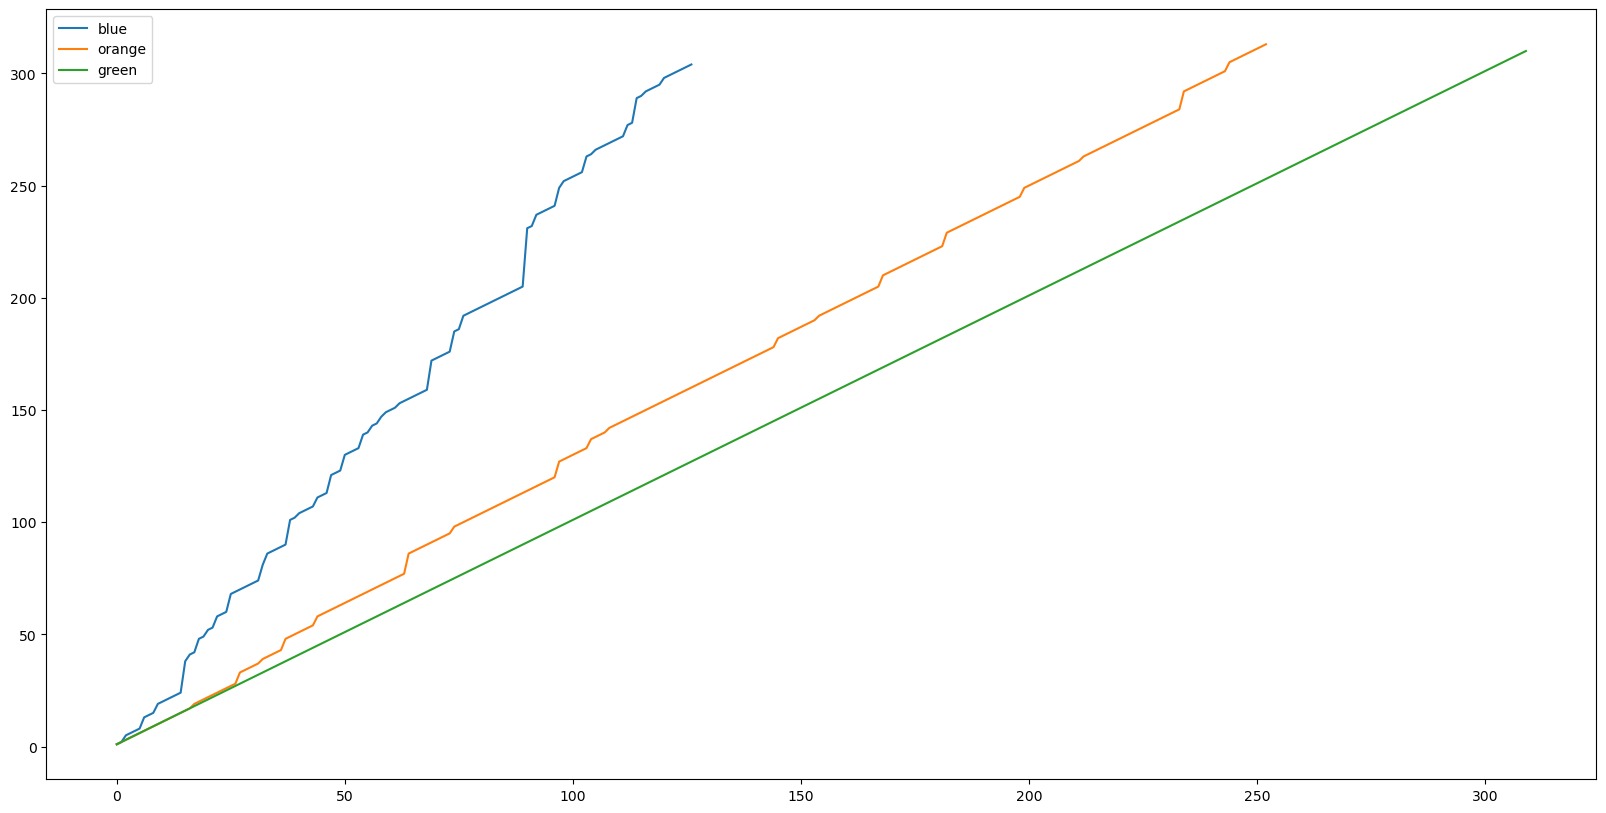

In [146]:
plt.plot(logical_clock_3, label = "blue")
plt.plot(logical_clock_2, label = "orange")
plt.plot(logical_clock_1, label = "green")
plt.legend()

In [149]:
logical_clock_diff_1 = [logical_clock_1[i+1] - logical_clock_1[i] for i in range(len(logical_clock_1) - 1)]
logical_clock_diff_2 = [logical_clock_2[i+1] - logical_clock_2[i] for i in range(len(logical_clock_2) - 1)]
logical_clock_diff_3 = [logical_clock_3[i+1] - logical_clock_3[i] for i in range(len(logical_clock_3) - 1)]

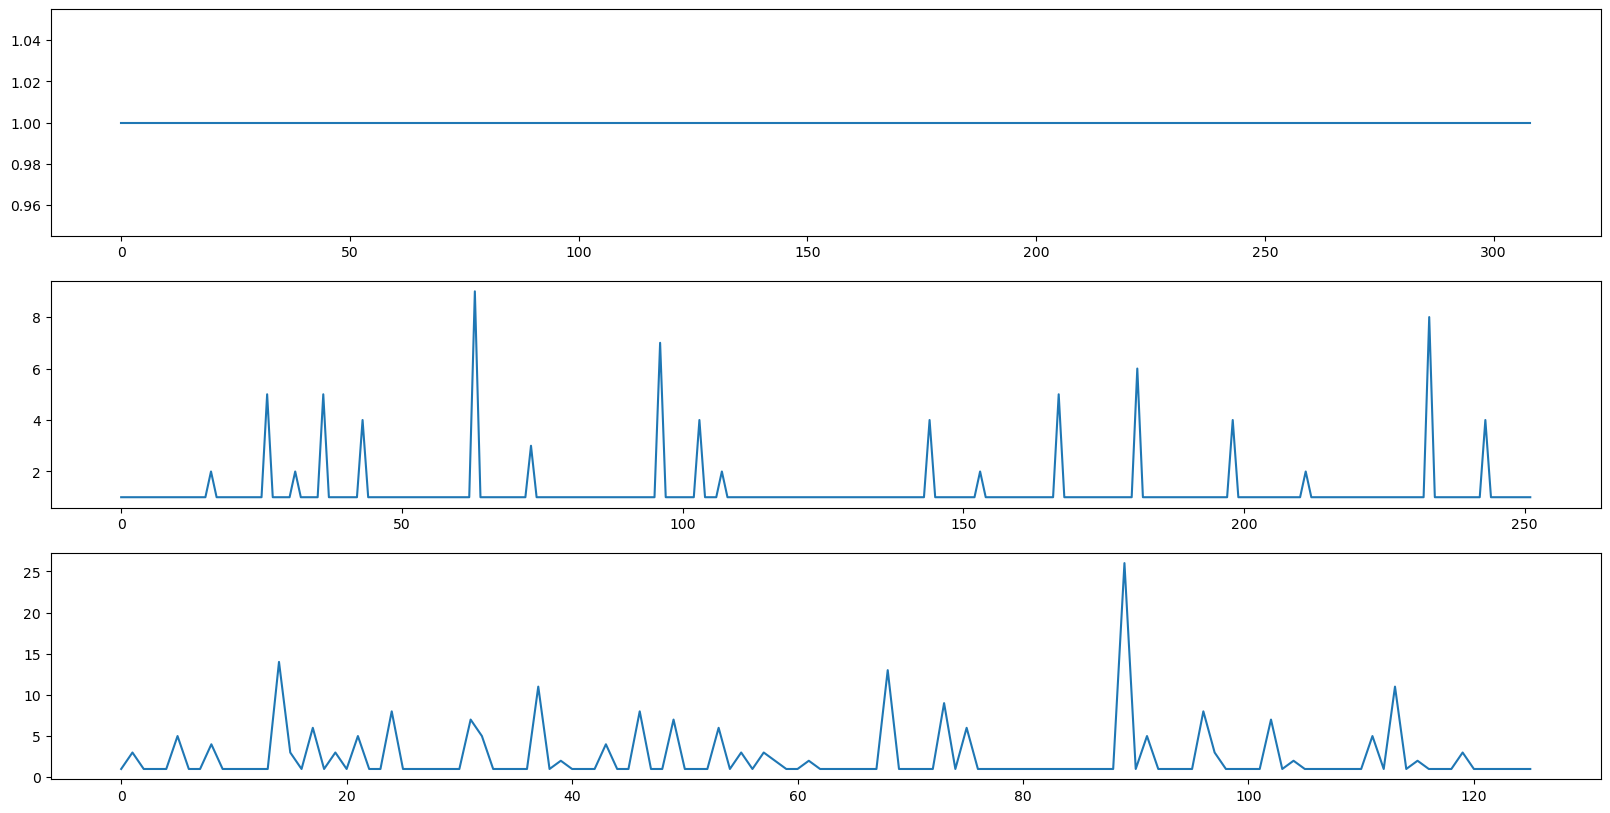

In [152]:
fig, axs = plt.subplots(3, 1)
axs[0].plot(logical_clock_diff_1, label = "blue")
axs[1].plot(logical_clock_diff_2, label = "orange")
axs[2].plot(logical_clock_diff_3, label = "green")